<a href="https://colab.research.google.com/github/flaviovdf/aae_bias/blob/main/TwiterAAE%20Logistic%20Human%20POS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code for our FACCT 24 submission

## Requirements.

In [1]:
from google.colab import userdata

In [2]:
# change these two links to the real repo url, hidden for reviewers
! git clone {userdata.get('aae_bias_repo')}
! mv aae_bias/data .

fatal: destination path 'aae_bias' already exists and is not an empty directory.
mv: cannot stat 'aae_bias/data': No such file or directory


In [3]:
# notebooks requires coraal and buckeye data in single folder
! cp -r data/buckeye/ data/cb
! cp data/coraal/* data/cb/

In [4]:
! pip install sentence-transformers
! pip install pyaml
! pip install flair
! pip install vaderSentiment
! pip install textblob
! pip install urllib3
! pip install detoxify

In [5]:
from statsmodels.distributions import ECDF
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

In [6]:
from detoxify import Detoxify

from flair.models import TextClassifier as FlairModel
from flair.data import Sentence as FlairSentence

from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as Vader

## Scoring functions

The datasets are re-scored with more recent version of methods. Perspective is the exception (requires API).

Also, the data files were originally scored without considering negative polarity.

In [7]:
def text_blob_score(txt):
    return TextBlob(txt).sentiment.polarity

vader = Vader()
def vader_score(txt):
    global vader
    pol = vader.polarity_scores(txt)
    neg = pol["neg"]
    return neg

def detoxify_all(df, unbiased=False):
    if not unbiased:
        model = Detoxify('original', device='cuda')
    else:
        model = Detoxify('unbiased', device='cuda')

    sentences = [x for x in df['text'].values]

    from itertools import islice

    results = []
    def chunker(it, size):
        iterator = iter(it)
        while chunk := list(islice(iterator, size)):
            results.extend(model.predict(chunk)['toxicity'])

    chunker(sentences, 128)
    return pd.Series(results, index=df.index)


def flair_score_all(df):
    flair = FlairModel.load('en-sentiment')
    sentences = [x for x in df['text'].apply(FlairSentence).values]
    flair.predict(sentences)

    return pd.Series(
        list(
            map(lambda s: s.score if s.labels[0]._value[0] == 'P' else -s.score,
                sentences
            )
        ), index=df.index
    )

    return sentences

In [8]:
plt.rcParams['figure.figsize'] = (3.3, 3.3  / 1.65)

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.ymargin'] = 0.1

plt.rcParams['font.family'] = 'serif'

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgrey'
plt.rcParams['grid.linewidth'] = .1

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = .5
plt.rcParams['xtick.minor.visible'] = True

plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = .5
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['legend.fontsize'] = 10

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 5

In [9]:
plt.style.use('tableau-colorblind10')
plt.ion();

In [10]:
import re

with open('./data/aae_terms_black_talk.yaml') as f:
    aae_t = yaml.safe_load(f)['terms']

aae_t = set(
    map(lambda s: s.
        replace(r"[^\w\d'\s]+", '').
        lower(),
        aae_t
    )
)

def count_aae(txt):
    return sum(
        map(lambda s: s in aae_t, txt.split())
    )

In [11]:
import os

def load_df(fold):
    if os.path.exists(f'{fold}.csv'):
        df = pd.read_csv(f'{fold}.csv').iloc[:, 1:]
        return df
    else:
        files = Path(f'data/{fold}').glob('*')

        dfs = []
        for f in files:
            data = pd.read_csv(f)
            data['file'] = f.stem
            dfs.append(data)

        df = pd.concat(dfs, ignore_index=True)

        df['detoxify_original_score'] = detoxify_all(df, False)
        df['detoxify_unbiased_score'] = detoxify_all(df, True)
        df['textblob_score'] = df['text'].apply(text_blob_score)
        df['vader_score'] = df['text'].apply(vader_score)
        df['flair_score'] = flair_score_all(df)

        df['clean_text'] = (
            df['text'].str.lower().
            str.replace(r"[^\w\d'\s]+", '', regex=True)
        )
        df = df.dropna()

        # df['aae_count'] = df['text'].str.count(r'|'.join(aae_t))
        df['aae_count'] = df['clean_text'].apply(count_aae)
        df = df.sort_index()
        df.to_csv(f'{fold}.csv')
        return df

In [12]:
def cdf_plots(df):
    fig, axes = plt.subplots(1, 6, figsize=(20, 3))
    i = 0
    for scorer in ['textblob_score',
                   'flair_score',
                   'vader_score',
                   'perspective_score',
                   'detoxify_original_score',
                   'detoxify_unbiased_score']:
        aae_cnt = df['aae_count']

        ax = axes[i]

        cm = plt.get_cmap('tab20c').colors
        sub = df[aae_cnt == 0]
        scores = sub[scorer]
        ecdf = ECDF(scores.values)
        ax.plot(ecdf.x, 1-ecdf.y, label='0 AAE Expr.', lw=1.5, color=cm[6])

        color = 15
        if fold == 'twitter':
            ks = [1, 3, 5]
        else:
            ks = [1, 3, 5, 7]
        for k in ks:
            sub = df[aae_cnt >= k]
            scores = sub[scorer]

            ecdf = ECDF(scores.values)
            ax.plot(ecdf.x, 1-ecdf.y, label=f'{k} or more', lw=1.5, color=cm[color])
            color = color - 1

        if i != 0:
            ax.tick_params(left = False)
            ax.yaxis.set_ticklabels([])
        else:
            ax.set(ylabel=r'$P[X \geq x]$')

        if scorer == 'textblob_score':
            ax.set(title='Textblob (L)', xlabel='x - Polarity')
            ax.set(xlim=(-1, 1))
            ax.vlines(0, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.1, 0.5, '➡ Positive Sent.', fontsize=8)
            ax.text(-0.8, 0.5, 'Negative Sent. ⬅', fontsize=8)
            ax.text(-0.98, 0.02, '↙ Majority of uttr\nare negative', fontsize=8)
            ax.text(0.30, 0.90, '↗ Majority of uttr\nare positive', fontsize=8)

        if scorer == 'flair_score':
            ax.set(title='Flair (ML)', xlabel='x - Polarity')
            ax.set(xlim=(-1, 1))
            ax.vlines(0, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.1, 0.5, '➡ Positive Sent.', fontsize=8)
            ax.text(-0.8, 0.5, 'Negative Sent. ⬅', fontsize=8)
            ax.text(-0.98, 0.02, '↙ Majority of uttr\nare negative', fontsize=8)
            ax.text(0.30, 0.90, '↗ Majority of uttr\nare positive', fontsize=8)

        if scorer == 'vader_score':
            ax.legend(loc='center right')
            ax.set(title='Vader (L)', xlabel='x - Neg. Probability')
            ax.set(xlim=(0, 1))
            ax.text(0.22, 0.45, 'Bias more\npresent\nbefore 0.20\nprob.', fontsize=8)
            ax.vlines(0.2, 0, 1, lw=1, ls='--', color='k', zorder=1)
            # ax.text(0.01, 0.02, '↙ Majority of uttr\nare not neg.', fontsize=8)
            ax.text(0.65, 0.90, '↗ Majority of uttr\nare neg.', fontsize=8)

        if scorer == 'detoxify_original_score':
            ax.set(title='Detoxify (ML)', xlabel='x - Toxic Probability')
            ax.set(xlim=(0, 1))
            ax.vlines(0.55, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.56, 0.5, 'Cut-off suggested by: \nMuralikumar et al.\n2023', fontsize=8)
            # ax.text(0.01, 0.30, '↙ Majority of uttr\nhave low scores.', fontsize=8)
            ax.text(0.65, 0.90, '↗ Majority of uttr\nhave high scores.', fontsize=8)

        if scorer == 'detoxify_unbiased_score':
            ax.set(title='Detoxify Unbiased (ML)', xlabel='x - Toxic Probability')
            ax.set(xlim=(0, 1))
            ax.vlines(0.55, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.56, 0.5, 'Cut-off suggested by: \nMuralikumar et al.\n2023', fontsize=8)
            # ax.text(0.01, 0.30, '↙ Majority of uttr\nhave low scores.', fontsize=8)
            ax.text(0.65, 0.90, '↗ Majority of uttr\nhave high scores.', fontsize=8)

        if scorer == 'perspective_score':
            ax.set(title='Perspective (ML)', xlabel='x - Toxic Probability')
            ax.set(xlim=(0, 1))
            ax.vlines(0.55, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.56, 0.5, 'Cut-off suggested by: \nMuralikumar et al.\n2023', fontsize=8)
            # ax.text(0.15, 0.30, '↙ Majority of uttr\nhave low scores.', fontsize=8)
            ax.text(0.65, 0.90, '↗ Majority of uttr\nhave high scores.', fontsize=8)
        ax.set(ylim=(0, 1))
        i += 1
    fig.tight_layout(pad=0)
    plt.show()
    plt.savefig(f'{fold}.pdf', bbox_inches = 'tight')

## Cumulative Distribution Functions

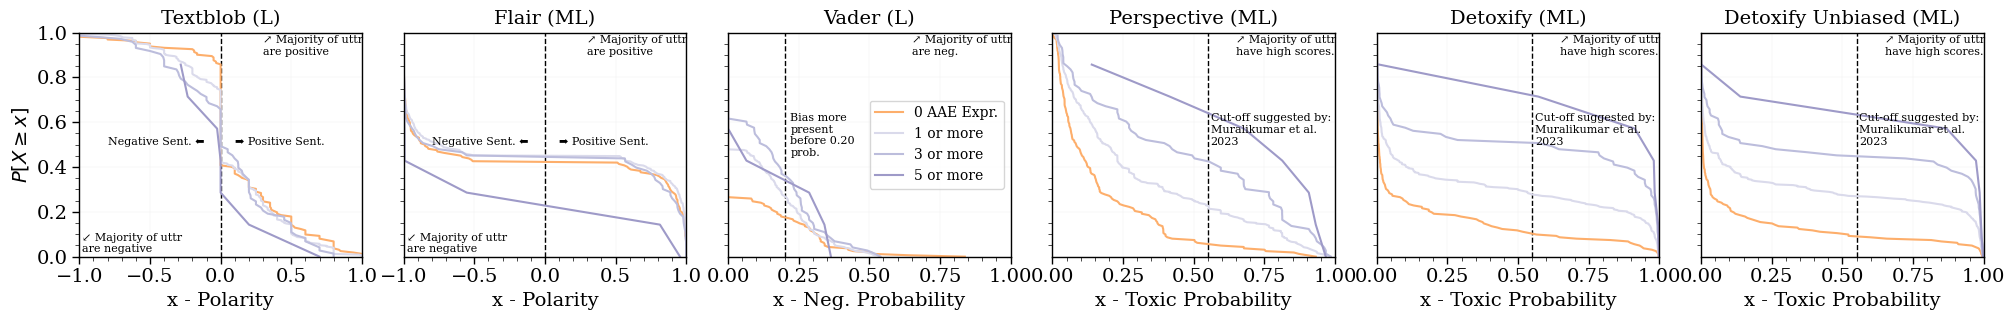

,text,perspective_score,flair_score,textblob_score,vader_score,detoxify_original_score,detoxify_unbiased_score,detoxify_multilingual_score,has_swearing,file,clean_text,aae_count
0,"how come i can never get in a "" gunning "" figh...",0.229829,0.720794,0.000000e+00,0.286,0.100590,0.074386,0.123957,False,wh_80,how come i can never get in a gunning fight ...,3
1,got tired of not having shit i strapped on my ...,0.813441,0.955784,-3.700743e-17,0.287,0.980441,0.972728,0.967041,True,aa_46,got tired of not having shit i strapped on my ...,5
2,pissed im not watching the indians game right now,0.464574,-0.993456,-5.714286e-02,0.344,0.363375,0.452306,0.214754,True,wh_149,pissed im not watching the indians game right now,1
3,lol he bouta piss me off .,0.151010,-0.725971,8.000000e-01,0.257,0.885897,0.470303,0.615071,True,aa_202,lol he bouta piss me off,1
4,i think it's so funny how people laugh at me w...,0.156848,0.999323,2.750000e-01,0.000,0.000817,0.002735,0.001120,False,wh_55,i think it's so funny how people laugh at me w...,1


<Figure size 330x200 with 0 Axes>

In [13]:
fold = 'twitter'
df = load_df(fold)
cdf_plots(df)
df.head()

In [14]:
! wget https://slanglab.cs.umass.edu/TwitterAAE/TwitterAAE-UD-v1.zip

--2024-03-21 14:43:11--  https://slanglab.cs.umass.edu/TwitterAAE/TwitterAAE-UD-v1.zip
Resolving slanglab.cs.umass.edu (slanglab.cs.umass.edu)... 128.119.246.182
Connecting to slanglab.cs.umass.edu (slanglab.cs.umass.edu)|128.119.246.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 325410 (318K) [application/zip]
Saving to: ‘TwitterAAE-UD-v1.zip.1’

TwitterAAE-UD-v1.zi 100%[===================>] 317.78K   348KB/s    in 0.9s    

2024-03-21 14:43:13 (348 KB/s) - ‘TwitterAAE-UD-v1.zip.1’ saved [325410/325410]



In [15]:
! unzip TwitterAAE-UD-v1.zip

Archive:  TwitterAAE-UD-v1.zip
replace TwitterAAE-UD-v1/wh250_gold.conllu? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [16]:
! pip install liwc

In [17]:
! wget https://raw.githubusercontent.com/Guilherme26/dissertation/main/data/LIWC2015_English_Flat.dic

--2024-03-21 14:44:12--  https://raw.githubusercontent.com/Guilherme26/dissertation/main/data/LIWC2015_English_Flat.dic
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118541 (116K) [text/plain]
Saving to: ‘LIWC2015_English_Flat.dic.1’

LIWC2015_English_Fl 100%[===================>] 115.76K  --.-KB/s    in 0.003s  

2024-03-21 14:44:12 (39.7 MB/s) - ‘LIWC2015_English_Flat.dic.1’ saved [118541/118541]



In [18]:
import liwc
liwc_parse, category_names = liwc.load_token_parser('LIWC2015_English_Flat.dic')

In [19]:
from collections import Counter

from conllu import parse
from conllu import parse_incr

data_file = open("TwitterAAE-UD-v1/all500_gold.conllu", "r", encoding="utf-8")
tags = []
for tokenlist in parse_incr(data_file):
    tags.append(tokenlist)

rows = []
for i in range(len(tags)):
    re = r'|'.join(
        str(tags[i])[10:-1].lower().split(', ')
    )

    pos_t = []
    for j in range(len(tags[i])):
        pos_t.append(tags[i][j]['deprel'])
    counter = Counter(pos_t)

    try:
        pos = df['text'].str.count(re).argmax()
        row = df.iloc[pos].to_dict()
        tokens = row['text'].split()
        liwc_counts = Counter(category for token in tokens for category in liwc_parse(token))
        row.update(counter)
        row.update(liwc_counts)
        rows.append(row)
    except:
        pass

In [41]:
df_regr = pd.DataFrame(rows).fillna(0)
df_regr = df_regr.drop('root', axis='columns')
df_regr = df_regr.drop('_', axis='columns')
df_regr['aae'] = df['file'].str.contains('aa').astype(int)
feats = [x for x in df_regr.columns[12:]]
feats = np.array(feats + ['aae_count'])
df_regr = df_regr.dropna()

In [50]:
# uncomment to filter features
# feats = feats[((df_regr[feats] > 0).mean() > 0.25)]
# feats

In [51]:
from sklearn.preprocessing import MinMaxScaler

In [52]:
import statsmodels.api as sm

In [53]:
for scorer in ['textblob_score',
                'flair_score',
                'vader_score',
                'perspective_score',
                'detoxify_original_score',
                'detoxify_unbiased_score']:
    y = df_regr[scorer]

    X = pd.DataFrame(
        MinMaxScaler().fit_transform(df_regr[feats].values),
        columns = feats,
        index = df_regr.index
    )
    X['intercept'] = 1

    if (y < 0).any():
        y = (y + 1) / 2

    model = sm.Logit(y, X).fit()
    print(scorer)
    print(model.summary())
    print()
    print()

Optimization terminated successfully.
         Current function value: 0.627132
         Iterations 5
textblob_score
                           Logit Regression Results                           
Dep. Variable:         textblob_score   No. Observations:                  441
Model:                          Logit   Df Residuals:                      384
Method:                           MLE   Df Model:                           56
Date:                Thu, 21 Mar 2024   Pseudo R-squ.:                 0.08721
Time:                        14:56:23   Log-Likelihood:                -276.57
converged:                       True   LL-Null:                       -302.99
Covariance Type:            nonrobust   LLR p-value:                    0.5950
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
nsubj            0.0675      0.745      0.091      0.928      -1.392       1.527
advmod  